# 01 Import libraries

In [1]:
import numpy as np
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [2]:
import pandas as pd

In [3]:
import importlib

In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
import lib
importlib.reload(lib)

<module 'lib' from 'c:\\Users\\dongq\\OneDrive\\Desktop\\New results\\Portfolio Allocation\\Learning-the-Optimal-Solution-Path\\lib\\__init__.py'>

In [6]:
from lib.lsp.basis_generator import bivariate_legendre, bivariate_chebyshev
from lib.lsp.learn_solution_path import learn_solution_path
from lib.lsp.loss_fn_lsp import allocation_cost
from lib.lsp.utils_lsp import get_sup_error_lsp_2d
from lib.fast_tensor_data_loader import FastTensorDataLoader

# 02 Instantiate dataset

In [177]:
# file path for Colab. May need to change this
# X_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/X_processed.csv')
# y_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/y_processed.csv')
decomp_cov_df = pd.read_csv('decomp_pert_20_cov.csv')
mean_df = pd.read_csv('mean.csv')

In [178]:
decomp_cov = np.array(decomp_cov_df)
mean = np.array(mean_df).squeeze()

In [179]:
decomp_cov = torch.tensor(decomp_cov, dtype=torch.float32)
mean = torch.tensor(mean, dtype=torch.float32)

In [207]:
identity_matrix = np.eye(len(decomp_cov))

decomp_cov = torch.tensor(identity_matrix, dtype=torch.float32)

In [226]:
decomp_cov

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [209]:
# full gradient descent uses all data points
GD_data_loader = FastTensorDataLoader(decomp_cov, mean, batch_size=len(decomp_cov), shuffle=False, )
# test data
test_data_loader = FastTensorDataLoader(decomp_cov, mean, batch_size=len(decomp_cov), shuffle=False, )

In [182]:
lam_max_2d = [1, 1]
lam_min_2d = [0.2, 0]
input_dim = decomp_cov.shape[1] - 1

In [222]:
# Read the CSV file into a DataFrame
# truth = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/results/exact_soln_list.csv')
truth = pd.read_csv('exact_soln_list_eye_001_20_20.csv')

# Display the DataFrame
truth

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.219092,-0.190589,-0.115112,-0.040314,0.054059,0.123610,0.181314,0.272299,0.331465,0.404117,0.470293,0.526220,0.591875,0.656062,0.718676,0.779608,0.838761,0.896065,0.951479,1.004988
1,-0.276610,-0.201379,-0.108065,0.015827,0.024259,0.097982,0.172538,0.242853,0.313806,0.383697,0.454987,0.519892,0.585970,0.650553,0.713530,0.774781,0.834197,0.891695,0.947229,1.000777
2,-0.289400,-0.212464,-0.136135,-0.060462,0.014499,0.118167,0.164083,0.234467,0.307670,0.376291,0.446597,0.516971,0.583114,0.644948,0.708311,0.769903,0.829602,0.887316,0.942976,0.996567
3,-0.171174,-0.140134,-0.147098,0.003319,0.026450,0.079114,0.152945,0.227395,0.298044,0.387329,0.450680,0.520853,0.579480,0.639236,0.703011,0.764971,0.825013,0.882913,0.938717,0.992356
4,-0.313394,-0.232472,-0.158385,-0.081803,-0.005905,0.077871,0.145380,0.217014,0.301200,0.360854,0.449732,0.501709,0.578373,0.633487,0.697620,0.760126,0.820309,0.878543,0.934455,0.988145
5,-0.280904,-0.247689,-0.170020,-0.092969,-0.015664,0.067519,0.133989,0.208007,0.280860,0.352783,0.430110,0.492986,0.561007,0.627596,0.692128,0.755191,0.815597,0.874059,0.930187,0.983935
6,-0.338509,-0.260163,-0.100022,-0.104235,-0.027621,0.055554,0.147911,0.227302,0.271962,0.344447,0.430124,0.500911,0.554355,0.621330,0.686520,0.749765,0.811148,0.869621,0.925913,0.979724
7,-0.352195,-0.273046,-0.194158,-0.116413,-0.038674,0.042276,0.118443,0.188626,0.262747,0.350128,0.414069,0.492973,0.549426,0.615046,0.680782,0.744510,0.806021,0.865147,0.921632,0.975514
8,-0.365968,-0.286361,-0.206751,-0.128621,-0.050850,0.052341,0.102833,0.211635,0.254820,0.326869,0.415850,0.470631,0.540418,0.610185,0.674897,0.740262,0.801135,0.860648,0.917343,0.971303
9,-0.380199,-0.300133,-0.179570,-0.136928,-0.063110,0.043357,0.092709,0.167920,0.257690,0.317563,0.406698,0.462635,0.533081,0.605174,0.668841,0.733990,0.796173,0.856120,0.913044,0.967093


In [223]:
true_losses = truth.to_numpy()

In [227]:
loss_fn = allocation_cost

# 03 Exact Gradient with Diminishing LR by Distance Diagnostic

We use diminishing learning rate for better demonstrate convergence. If we use a constant learning rate, the solution path error will eventually do a random walk after descending to a certain threshold value.

Set weighted_avg to 'False' see this random walk.

In [186]:
max_epochs = 1000

In [187]:
phi_lam = bivariate_legendre
# phi_lam = bivariate_chebyshev

In [188]:
def thresh_basis(basis_dim):
    return 1e-9

In [228]:
basis_dim = 1
init_lr = .5**5

np.random.seed(8675309)
torch.manual_seed(8675309)

num_itr_history, sup_err_history, weight, lr, itr = learn_solution_path(input_dim, basis_dim, phi_lam, max_epochs,
                                                               GD_data_loader, test_data_loader, loss_fn,
                                                               lam_min_2d, lam_max_2d, true_losses, init_lr=init_lr,
                                                               diminish=False, gamma=0.97, q=1.5, k_0=5,
                                                               intercept=False, thresh_basis=thresh_basis,
                                                               record_fctn=get_sup_error_lsp_2d,
                                                               record_frequency=10, distribution='uniform',
                                                               device=device, trace_frequency=10)
sup_err_history_1 = np.array(sup_err_history)

--------approximate solution path for # itr = 10 complete--------
# epoch: 10	 sup error: 0.28579441618008405
--------approximate solution path for # itr = 20 complete--------
# epoch: 20	 sup error: 0.26584855627102644
--------approximate solution path for # itr = 30 complete--------
# epoch: 30	 sup error: 0.5292144210247496
--------approximate solution path for # itr = 40 complete--------
# epoch: 40	 sup error: 0.3466647059826353
--------approximate solution path for # itr = 50 complete--------
# epoch: 50	 sup error: 0.26134471010250837
--------approximate solution path for # itr = 60 complete--------
# epoch: 60	 sup error: 0.2627659232525328
--------approximate solution path for # itr = 70 complete--------
# epoch: 70	 sup error: 0.24314705442471296
--------approximate solution path for # itr = 80 complete--------
# epoch: 80	 sup error: 0.23161200593991071
--------approximate solution path for # itr = 90 complete--------
# epoch: 90	 sup error: 0.22835735391659528
--------appro

In [229]:
basis_dim = 2
init_lr = .5**6

np.random.seed(8675309)
torch.manual_seed(8675309)

num_itr_history, sup_err_history, weight, lr, itr = learn_solution_path(input_dim, basis_dim, phi_lam, max_epochs,
                                                               GD_data_loader, test_data_loader, loss_fn,
                                                               lam_min_2d, lam_max_2d, true_losses, init_lr=init_lr,
                                                               diminish=False, gamma=0.97, q=1.5, k_0=5,
                                                               intercept=False, thresh_basis=thresh_basis,
                                                               record_fctn=get_sup_error_lsp_2d,
                                                               record_frequency=10, distribution='uniform',
                                                               device=device, trace_frequency=10)
sup_err_history_2 = np.array(sup_err_history)

--------approximate solution path for # itr = 10 complete--------
# epoch: 10	 sup error: 1.2627870542948885
--------approximate solution path for # itr = 20 complete--------
# epoch: 20	 sup error: 0.4329934418457376
--------approximate solution path for # itr = 30 complete--------
# epoch: 30	 sup error: 0.2256749064831236
--------approximate solution path for # itr = 40 complete--------
# epoch: 40	 sup error: 0.26530138563198835
--------approximate solution path for # itr = 50 complete--------
# epoch: 50	 sup error: 0.19548718046231062
--------approximate solution path for # itr = 60 complete--------
# epoch: 60	 sup error: 0.22831062387509138
--------approximate solution path for # itr = 70 complete--------
# epoch: 70	 sup error: 0.22449068140072614
--------approximate solution path for # itr = 80 complete--------
# epoch: 80	 sup error: 0.24212400030178816
--------approximate solution path for # itr = 90 complete--------
# epoch: 90	 sup error: 0.25141231130642683
--------appro

In [230]:
basis_dim = 3
init_lr = .5**7

np.random.seed(8675309)
torch.manual_seed(8675309)

num_itr_history, sup_err_history, weight, lr, itr = learn_solution_path(input_dim, basis_dim, phi_lam, max_epochs,
                                                               GD_data_loader, test_data_loader, loss_fn,
                                                               lam_min_2d, lam_max_2d, true_losses, init_lr=init_lr,
                                                               diminish=False, gamma=0.97, q=1.5, k_0=5,
                                                               intercept=False, thresh_basis=thresh_basis,
                                                               record_fctn=get_sup_error_lsp_2d,
                                                               record_frequency=10, distribution='uniform',
                                                               device=device, trace_frequency=10)
sup_err_history_3 = np.array(sup_err_history)

--------approximate solution path for # itr = 10 complete--------
# epoch: 10	 sup error: 0.637739430183713
--------approximate solution path for # itr = 20 complete--------
# epoch: 20	 sup error: 0.6260092956965609
--------approximate solution path for # itr = 30 complete--------
# epoch: 30	 sup error: 0.31290570806546003
--------approximate solution path for # itr = 40 complete--------
# epoch: 40	 sup error: 0.2813799769787291
--------approximate solution path for # itr = 50 complete--------
# epoch: 50	 sup error: 0.27109102319760114
--------approximate solution path for # itr = 60 complete--------
# epoch: 60	 sup error: 0.2651383073238829
--------approximate solution path for # itr = 70 complete--------
# epoch: 70	 sup error: 0.25770274709744245
--------approximate solution path for # itr = 80 complete--------
# epoch: 80	 sup error: 0.2546625525860289
--------approximate solution path for # itr = 90 complete--------
# epoch: 90	 sup error: 0.24942425798458845
--------approxim

In [231]:
basis_dim = 4
init_lr = .5**8

np.random.seed(8675309)
torch.manual_seed(8675309)

num_itr_history, sup_err_history, weight, lr, itr = learn_solution_path(input_dim, basis_dim, phi_lam, max_epochs,
                                                               GD_data_loader, test_data_loader, loss_fn,
                                                               lam_min_2d, lam_max_2d, true_losses, init_lr=init_lr,
                                                               diminish=True, gamma=0.97, q=1.5, k_0=5,
                                                               intercept=False, thresh_basis=thresh_basis,
                                                               record_fctn=get_sup_error_lsp_2d,
                                                               record_frequency=10, distribution='uniform',
                                                               device=device, trace_frequency=10)
sup_err_history_4 = np.array(sup_err_history)

--------approximate solution path for # itr = 10 complete--------
# epoch: 10	 sup error: 0.7559028370326205
--------approximate solution path for # itr = 20 complete--------
# epoch: 20	 sup error: 0.49807540487332136
--------approximate solution path for # itr = 30 complete--------
# epoch: 30	 sup error: 0.9608226938922443
--------approximate solution path for # itr = 40 complete--------
# epoch: 40	 sup error: 1.8595964832980671
--------approximate solution path for # itr = 50 complete--------
# epoch: 50	 sup error: 0.3694460780529478
--------approximate solution path for # itr = 60 complete--------
# epoch: 60	 sup error: 0.8945593758304157
--------approximate solution path for # itr = 70 complete--------
# epoch: 70	 sup error: 0.6460595055301227
--------approximate solution path for # itr = 80 complete--------
# epoch: 80	 sup error: 0.3587247521786192
--------approximate solution path for # itr = 90 complete--------
# epoch: 90	 sup error: 0.3425283820538023
--------approximat

In [233]:
basis_dim = 5
init_lr = .5**11

np.random.seed(8675309)
torch.manual_seed(8675309)

num_itr_history, sup_err_history, weight, lr, itr = learn_solution_path(input_dim, basis_dim, phi_lam, max_epochs,
                                                               GD_data_loader, test_data_loader, loss_fn,
                                                               lam_min_2d, lam_max_2d, true_losses, init_lr=init_lr,
                                                               diminish=False, gamma=0.97, q=1.5, k_0=5,
                                                               intercept=False, thresh_basis=thresh_basis,
                                                               record_fctn=get_sup_error_lsp_2d,
                                                               record_frequency=10, distribution='uniform',
                                                               device=device, trace_frequency=10)
sup_err_history_5 = np.array(sup_err_history)

--------approximate solution path for # itr = 10 complete--------
# epoch: 10	 sup error: 1.1923091926947393
--------approximate solution path for # itr = 20 complete--------
# epoch: 20	 sup error: 1.0161943264812276
--------approximate solution path for # itr = 30 complete--------
# epoch: 30	 sup error: 1.6176493092258015
--------approximate solution path for # itr = 40 complete--------
# epoch: 40	 sup error: 2.737817041464571
--------approximate solution path for # itr = 50 complete--------
# epoch: 50	 sup error: 2.6996612473208943
--------approximate solution path for # itr = 60 complete--------
# epoch: 60	 sup error: 1.0330216808993855
--------approximate solution path for # itr = 70 complete--------
# epoch: 70	 sup error: 1.2137060089786091
--------approximate solution path for # itr = 80 complete--------
# epoch: 80	 sup error: 1.2901165409762898
--------approximate solution path for # itr = 90 complete--------
# epoch: 90	 sup error: 1.1141157074649373
--------approximate 

In [131]:
sup_err_history = pd.DataFrame(sup_err_history_5)

# Save the DataFrame to a CSV file
sup_err_history.to_csv('sup_err_history_5_pert_10_1_20_20.csv', index=False)

In [137]:
NGS_results_exact = pd.read_csv('NGS_results_exact_2d.csv')
num_itr_NGS_exact = np.array(NGS_results_exact['num_itr'])
sup_err_NGS_exact = np.array(NGS_results_exact['sup_err'])

In [114]:
import matplotlib.pyplot as plt

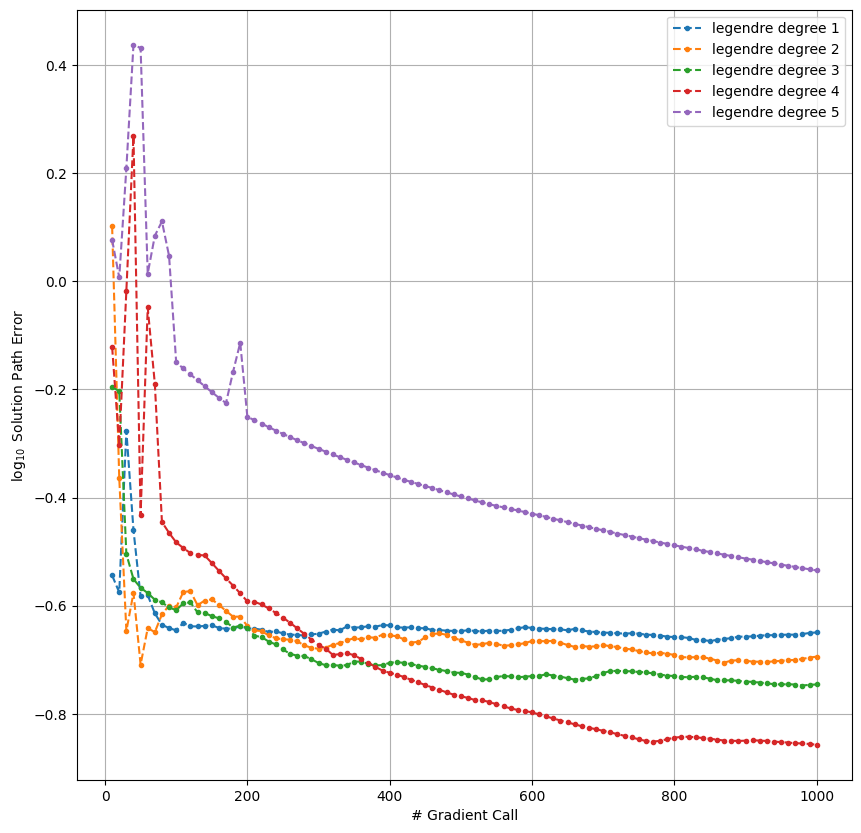

In [234]:
# plot result of our method:
plt.figure(figsize=(10,10))
# plt.plot(num_itr_NGS_exact[:5], np.log10(sup_err_NGS_exact[:5]), '--.', label=f'uniform discretization')
plt.plot(np.linspace(10, 1000, 100), np.log10(sup_err_history_1), '--.', label=f'legendre degree 1')
plt.plot(np.linspace(10, 1000, 100), np.log10(sup_err_history_2), '--.', label=f'legendre degree 2')
plt.plot(np.linspace(10, 1000, 100), np.log10(sup_err_history_3), '--.', label=f'legendre degree 3')
plt.plot(np.linspace(10, 1000, 100), np.log10(sup_err_history_4), '--.', label=f'legendre degree 4')
plt.plot(np.linspace(10, 1000, 100), np.log10(sup_err_history_5), '--.', label=f'legendre degree 5')
# i=5
# plt.plot(thetastar[start:start+10, 1], thetastar[start:start+10, i], '--o', label=f'lam_1 = {thetastar[start, 0]}, $\\theta${i+1}')
plt.xlabel(f'# Gradient Call')
plt.ylabel("$\\log_{10}$ Solution Path Error")
plt.legend()
plt.grid(True)

## num basis func = 5

In [88]:
basis_dim = 2
init_lr = .5**9

In [64]:
# pert = 10, mu = .01
np.random.seed(8675309)
torch.manual_seed(8675309)

num_itr_history, sup_err_history, weight, lr, itr = learn_solution_path(input_dim, basis_dim, phi_lam, max_epochs,
                                                               GD_data_loader, test_data_loader, loss_fn,
                                                               lam_min_2d, lam_max_2d, true_losses, init_lr=init_lr,
                                                               diminish=True, gamma=0.97, q=1.5, k_0=5,
                                                               intercept=False, thresh_basis=thresh_basis,
                                                               record_fctn=get_sup_error_lsp_2d,
                                                               record_frequency=10, distribution='uniform',
                                                               device=device, trace_frequency=10)
sup_err_history = np.array(sup_err_history)

--------approximate solution path for # itr = 10 complete--------
# epoch: 10	 sup error: 2.1330595817428666
--------approximate solution path for # itr = 20 complete--------
# epoch: 20	 sup error: 1.0995703544479447
--------approximate solution path for # itr = 30 complete--------
# epoch: 30	 sup error: 0.46592720411835487
--------approximate solution path for # itr = 40 complete--------
# epoch: 40	 sup error: 0.22616108320771033
--------approximate solution path for # itr = 50 complete--------
# epoch: 50	 sup error: 0.136600574479683
--------approximate solution path for # itr = 60 complete--------
# epoch: 60	 sup error: 0.12942131422577674
--------approximate solution path for # itr = 70 complete--------
# epoch: 70	 sup error: 0.1136074867111283
--------approximate solution path for # itr = 80 complete--------
# epoch: 80	 sup error: 0.09897144697724158
--------approximate solution path for # itr = 90 complete--------
# epoch: 90	 sup error: 0.0837450828414994
--------approxim

In [50]:
# pert = 20, mu = .01
np.random.seed(8675309)
torch.manual_seed(8675309)

num_itr_history, sup_err_history, weight, lr, itr = learn_solution_path(input_dim, basis_dim, phi_lam, max_epochs,
                                                               GD_data_loader, test_data_loader, loss_fn,
                                                               lam_min_2d, lam_max_2d, true_losses, init_lr=init_lr,
                                                               diminish=True, gamma=0.97, q=1.5, k_0=5,
                                                               intercept=False, thresh_basis=thresh_basis,
                                                               record_fctn=get_sup_error_lsp_2d,
                                                               record_frequency=10, distribution='uniform',
                                                               device=device, trace_frequency=10)
sup_err_history = np.array(sup_err_history)

--------approximate solution path for # itr = 10 complete--------
# epoch: 10	 sup error: 1.395437542120579
--------approximate solution path for # itr = 20 complete--------
# epoch: 20	 sup error: 0.6059535180727273
--------approximate solution path for # itr = 30 complete--------
# epoch: 30	 sup error: 0.20725280396139922
--------approximate solution path for # itr = 40 complete--------
# epoch: 40	 sup error: 0.08794623963034454
--------approximate solution path for # itr = 50 complete--------
# epoch: 50	 sup error: 0.06200344980560368
--------approximate solution path for # itr = 60 complete--------
# epoch: 60	 sup error: 0.06035359323822087
--------approximate solution path for # itr = 70 complete--------
# epoch: 70	 sup error: 0.05868847788177556
--------approximate solution path for # itr = 80 complete--------
# epoch: 80	 sup error: 0.056518391974793136
--------approximate solution path for # itr = 90 complete--------
# epoch: 90	 sup error: 0.055300549872742355
--------app

In [87]:
# pert = 10, mu = 1
np.random.seed(8675309)
torch.manual_seed(8675309)

num_itr_history, sup_err_history, weight, lr, itr = learn_solution_path(input_dim, basis_dim, phi_lam, max_epochs,
                                                               GD_data_loader, test_data_loader, loss_fn,
                                                               lam_min_2d, lam_max_2d, true_losses, init_lr=init_lr,
                                                               diminish=True, gamma=0.97, q=1.5, k_0=5,
                                                               intercept=False, thresh_basis=thresh_basis,
                                                               record_fctn=get_sup_error_lsp_2d,
                                                               record_frequency=10, distribution='uniform',
                                                               device=device, trace_frequency=10)
sup_err_history = np.array(sup_err_history)

--------approximate solution path for # itr = 10 complete--------
# epoch: 10	 sup error: 2.2300690342512297
--------approximate solution path for # itr = 20 complete--------
# epoch: 20	 sup error: 1.0966643025007414
--------approximate solution path for # itr = 30 complete--------
# epoch: 30	 sup error: 0.4246033360090422
--------approximate solution path for # itr = 40 complete--------
# epoch: 40	 sup error: 0.1995342899885344
--------approximate solution path for # itr = 50 complete--------
# epoch: 50	 sup error: 0.12374674573804612
--------approximate solution path for # itr = 60 complete--------
# epoch: 60	 sup error: 0.11681544080640549
--------approximate solution path for # itr = 70 complete--------
# epoch: 70	 sup error: 0.10337244764234299
--------approximate solution path for # itr = 80 complete--------
# epoch: 80	 sup error: 0.09041487470533127
--------approximate solution path for # itr = 90 complete--------
# epoch: 90	 sup error: 0.07798754468824143
--------approx

In [89]:
# pert = 10, mu = 1
np.random.seed(8675309)
torch.manual_seed(8675309)

num_itr_history, sup_err_history, weight, lr, itr = learn_solution_path(input_dim, basis_dim, phi_lam, max_epochs,
                                                               GD_data_loader, test_data_loader, loss_fn,
                                                               lam_min_2d, lam_max_2d, true_losses, init_lr=init_lr,
                                                               diminish=True, gamma=0.97, q=1.5, k_0=5,
                                                               intercept=False, thresh_basis=thresh_basis,
                                                               record_fctn=get_sup_error_lsp_2d,
                                                               record_frequency=10, distribution='uniform',
                                                               device=device, trace_frequency=10)
sup_err_history = np.array(sup_err_history)

--------approximate solution path for # itr = 10 complete--------
# epoch: 10	 sup error: 0.865192287119882
--------approximate solution path for # itr = 20 complete--------
# epoch: 20	 sup error: 0.3211258110456612
--------approximate solution path for # itr = 30 complete--------
# epoch: 30	 sup error: 0.1091717411604094
--------approximate solution path for # itr = 40 complete--------
# epoch: 40	 sup error: 0.04805933729078049
--------approximate solution path for # itr = 50 complete--------
# epoch: 50	 sup error: 0.037113688695682434
--------approximate solution path for # itr = 60 complete--------
# epoch: 60	 sup error: 0.03768255542541876
--------approximate solution path for # itr = 70 complete--------
# epoch: 70	 sup error: 0.037429831731571106
--------approximate solution path for # itr = 80 complete--------
# epoch: 80	 sup error: 0.037057183492435364
--------approximate solution path for # itr = 90 complete--------
# epoch: 90	 sup error: 0.03690554927612677
--------app

In [78]:
# pert = 20, mu = 1
np.random.seed(8675309)
torch.manual_seed(8675309)

num_itr_history, sup_err_history, weight, lr, itr = learn_solution_path(input_dim, basis_dim, phi_lam, max_epochs,
                                                               GD_data_loader, test_data_loader, loss_fn,
                                                               lam_min_2d, lam_max_2d, true_losses, init_lr=init_lr,
                                                               diminish=True, gamma=0.97, q=1.5, k_0=5,
                                                               intercept=False, thresh_basis=thresh_basis,
                                                               record_fctn=get_sup_error_lsp_2d,
                                                               record_frequency=10, distribution='uniform',
                                                               device=device, trace_frequency=10)
sup_err_history = np.array(sup_err_history)

--------approximate solution path for # itr = 10 complete--------
# epoch: 10	 sup error: 1.4764827506551903
--------approximate solution path for # itr = 20 complete--------
# epoch: 20	 sup error: 0.6163912000333411
--------approximate solution path for # itr = 30 complete--------
# epoch: 30	 sup error: 0.18730580973722155
--------approximate solution path for # itr = 40 complete--------
# epoch: 40	 sup error: 0.07223355937101061
--------approximate solution path for # itr = 50 complete--------
# epoch: 50	 sup error: 0.04013288188077624
--------approximate solution path for # itr = 60 complete--------
# epoch: 60	 sup error: 0.037550331831948114
--------approximate solution path for # itr = 70 complete--------
# epoch: 70	 sup error: 0.032667519331948114
--------approximate solution path for # itr = 80 complete--------
# epoch: 80	 sup error: 0.02823102641202624
--------approximate solution path for # itr = 90 complete--------
# epoch: 90	 sup error: 0.02533862877256965
--------ap

In [24]:
file_path = 'LSP_results_exact_fixed_basis_2d.csv'

LSP_results_exact_fixed_basis = pd.DataFrame(np.column_stack((num_itr_history, sup_err_history)), columns=['num_itr', 'sup_err_5'])

# Save the DataFrame to a CSV file
LSP_results_exact_fixed_basis.to_csv(file_path, index=False)

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the DataFrame
df

,num_itr,sup_err_5
0,10.0,2.266643
1,20.0,2.301398
2,30.0,1.218391
3,40.0,0.984176
4,50.0,0.735405
...,...,...
195,1960.0,0.165899
196,1970.0,0.165998
197,1980.0,0.166104
198,1990.0,0.166114


## num basis func = 7

In [132]:
basis_dim = 7
init_lr = .5**7

In [133]:
np.random.seed(8675309)
torch.manual_seed(8675309)

num_itr_history, sup_err_history, weight, lr, itr = learn_solution_path(input_dim, basis_dim, phi_lam, max_epochs,
                                                               GD_data_loader, test_data_loader, loss_fn,
                                                               lam_min_2d, lam_max_2d, true_losses, init_lr=init_lr,
                                                               diminish=True, gamma=0.97, q=1.5, k_0=5,
                                                               intercept=False, thresh_basis=thresh_basis,
                                                               record_fctn=get_sup_error_lsp_2d,
                                                               record_frequency=10, distribution='semicircle',
                                                               device=device, trace_frequency=10)
sup_err_history = np.array(sup_err_history)

--------approximate solution path for # itr = 10 complete--------
# epoch: 10	 sup error: 0.6868343353271467
--------approximate solution path for # itr = 20 complete--------
# epoch: 20	 sup error: 0.29451465606689275
--------approximate solution path for # itr = 30 complete--------
# epoch: 30	 sup error: 0.1821727752685529
--------approximate solution path for # itr = 40 complete--------
# epoch: 40	 sup error: 0.11758828163146973
--------approximate solution path for # itr = 50 complete--------
# epoch: 50	 sup error: 0.10061860084533691
--------approximate solution path for # itr = 60 complete--------
# epoch: 60	 sup error: 0.10180938243865967
--------approximate solution path for # itr = 70 complete--------
# epoch: 70	 sup error: 0.10091090202331543
--------approximate solution path for # itr = 80 complete--------
# epoch: 80	 sup error: 0.09847962856292725
--------approximate solution path for # itr = 90 complete--------
# epoch: 90	 sup error: 0.09614682197570801
--------appr

In [ ]:
file_path = 'LSP_results_exact_fixed_basis_2d.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

df['sup_err_7'] = sup_err_history

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False)

## num basis func = 9

In [47]:
basis_dim = 9
init_lr = .5**9

In [48]:
np.random.seed(8675309)
torch.manual_seed(8675309)

num_itr_history, sup_err_history, weight, lr, itr = learn_solution_path(input_dim, basis_dim, phi_lam, max_epochs,
                                                               GD_data_loader, test_data_loader, loss_fn,
                                                               lam_min_2d, lam_max_2d, true_losses, init_lr=init_lr,
                                                               diminish=True, gamma=0.97, q=1.3, k_0=5,
                                                               intercept=False, thresh_basis=thresh_basis,
                                                               record_fctn=get_sup_error_lsp_2d,
                                                               record_frequency=10, distribution='wiener',
                                                               device=device, trace_frequency=10)
sup_err_history = np.array(sup_err_history)

--------approximate solution path for # itr = 10 complete--------
# epoch: 10	 sup error: 2.1024417877197283
--------approximate solution path for # itr = 20 complete--------
# epoch: 20	 sup error: 1.2936506271362322
--------approximate solution path for # itr = 30 complete--------
# epoch: 30	 sup error: 0.9063892364501971
--------approximate solution path for # itr = 40 complete--------
# epoch: 40	 sup error: 0.6882791519165057
--------approximate solution path for # itr = 50 complete--------
# epoch: 50	 sup error: 0.5487918853759783
--------approximate solution path for # itr = 60 complete--------
# epoch: 60	 sup error: 0.5310268402099627
--------approximate solution path for # itr = 70 complete--------
# epoch: 70	 sup error: 0.497444152832033
--------approximate solution path for # itr = 80 complete--------
# epoch: 80	 sup error: 0.46015262603759943
--------approximate solution path for # itr = 90 complete--------
# epoch: 90	 sup error: 0.423927307128908
--------approximate 

KeyboardInterrupt: 

In [ ]:
file_path = 'LSP_results_exact_fixed_basis_2d.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

df['sup_err_9'] = sup_err_history

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False)